### YOLO object detection architecture


### You Only Look Once: Unified, Real-Time Object Detection (Redmon J. et al. , 2016)
[Paper](https://arxiv.org/abs/1506.02640)


*...we frame object detection as a regression problem to spatially separated bounding boxes and associated class probabilities. A single neural network predicts bounding boxes and class probabilities directly from full images in one evaluation.*

In [1]:
import os
import glob
import numpy as np
from typing import Tuple, Callable

import cv2

import netron
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision

from ignite.engine import create_supervised_evaluator
from ignite.metrics import Loss

import matplotlib.pyplot as plt

assert torch.cuda.is_available() is True
%load_ext watermark

In [2]:
%watermark -p torch,ignite,numpy,cv2,sklearn

torch  : 1.10.2
ignite : 0.4.8
numpy  : 1.22.1
cv2    : 4.5.5
sklearn: 0.24.2



<img src="../assets/1_yolo.png" width="550">

* S x S grid on input, default S=7.


* If the center of an object falls into a grid cell, that grid cell is responsible for detecting that object.


* Each grid cell has output tensor $1 x 1 x(5 * B + C)$, $C$ - number of classes, $B$ - numbder of predicted bboxes.


Intuition:
<img src="../assets/3_yolo.svg" width="850">



Assumption: *Multiple object centers can't exist in one grid cell.*


* Bbox: $(x, y, w, h, p_{object})$

    * (x, y) - the center of the box relative to the bounds of the grid cell, 
    * w & h - relative to the whole image
    * $p_{object}$ - the confidence value that a grid cell contains an object
    
If $W_x, W_y - $ cell size, $C_x, C_y$ - object center coordinates relative to the upper left corner of the cell,  then:

$$ x = \frac{Cx}{W_x}, $$

$$ y = \frac{C_y}{W_y}, $$ 

$$ h = \frac{H_{object}}{H}, $$

$$ h = \frac{W_{object}}{W}. $$

During taining, a bounding box for a particular cell = (x, y, w, h, 1), if center is in this cell. Empty cells have zero values in output vectors.






GoogLeNet-inspired YOLOv1:
<img src="../assets/2_yolo.png" width="850">





* Multi-part loss fucntion:

$Loss_{total} = \sum_i^{S \cdot S}L(i)$

$L(i) = \mathbb{1}^{obj}[L_{class}(i) + \lambda_{coord}L_{coord}(i) + L_{conf}(i)] + \mathbb{1}^{noobj}\lambda_{noobj}L_{noobj}(i) $

[Loss details](https://arxiv.org/pdf/1506.02640.pdf)

In [3]:
import utils
import metrics
import training

In [4]:
class ShapesDataset(Dataset):

    def __init__(self, n_images: int, img_size: int, seed: int, transform: Callable = None, 
                 name: str = 'default', verbose: bool = False):
        """
        Map-style ShapesDataset. YOLO version.

        :param n_images:          number of images to generate
        :param img_size:          crop image size
        :param transform:         final crops transformations
        :param name:              dataset name
        :param verbose:           class versbosity
        """
        self.n_images = n_images
        self.transform = transform
        self.img_size = img_size
        self.shapes2d = utils.RandomShapes(
            img_size=self.img_size, w=50, h=50, nms_threshold=0.1, 
            background_class=False, seed=seed)
        self.name = name
        self.verbose = verbose
        self.fast_ssearch = True

        self._generate_dataset()
        
        self.S = 7
        self.B = 2
        self.C = len(self.shapes2d.classes)
        self.cell_size = self.img_size // self.S
        
        self.show_color = (250, 0, 0)
        self.grid_color = (0, 250, 0)

    @staticmethod
    def extract_gtruth(gtruth: list) -> Tuple[np.ndarray, int]:
        gt_bbox = [gt for _, gt in gtruth]
        gt_class_id = [idx for idx, _ in gtruth]
        return gt_bbox, gt_class_id

    @staticmethod
    def show_image(image: np.ndarray, title: str) -> None:
        fig = plt.figure()
        plt.imshow(image)
        plt.title(title)
        plt.axis('off')
    
    def show_bboxes(self, idx: int, centers: bool = True, grid: bool = True) -> None:
        image = self._get_image(idx)
        boxes = self._get_boxes(idx)
        if grid:
            image = self._draw_grid(image)
        for box in boxes:
            image = cv2.rectangle(image, box, self.show_color, 1)
            if centers:
                image = self._draw_point(image, box[:2] + box[2:]//2)
        self.show_image(image, 'Ground truth')
        
    def show_cell_info(self, row: int, col: int, idx: int) -> None:
        _, target = self.__getitem__(idx)
        show_boxes = target[row][col][:train_dataset.B*5].reshape(train_dataset.B, 5)
        show_labels = target[row][col][train_dataset.B*5:]
        class_id = np.argmax(show_labels)
        if class_id:
            class_name = train_dataset.shapes2d.classes[int(np.argmax(show_labels))]
        else:
            class_name = 'empty cell'
        print(f'\nCell: [{row}][{col}]')
        print(f'Boxes:\n{show_boxes}\nClass confidence: {show_labels}\nName:{class_name}')
        
    def _draw_grid(self, image: np.ndarray) -> np.ndarray:
        for x in list(range(0, self.img_size, self.cell_size)):
            for y in list(range(0, self.img_size, self.cell_size)):
                w = x + self.cell_size
                h = y + self.cell_size
                image = cv2.rectangle(image, (x, y, w, h), self.grid_color, 1)
        return image 
    
    def _draw_point(self, image: np.ndarray, box: np.ndarray) -> np.ndarray:
        image = cv2.circle(image, box, 2, self.show_color, -1)
        return image

    def _generate_dataset(self) -> None:
        print(f'{self.name} Generating dataset...')
        self.images_info = {}
        for i in range(self.n_images):
            bg_color, shape_specs, gtruths = self.shapes2d.generate_shapes()
            self.images_info.update({i: {'bg_color': bg_color,
                                         'shape_specs': shape_specs,
                                         'gtruths': gtruths
                                         }
                                     }
                                    )
    
    def _encode(self, boxes: torch.Tensor, labels: torch.Tensor) -> torch.Tensor:
        """ 
        Source: https://github.com/motokimura/yolo_v1_pytorch
        Encode box coordinates and class labels into a tensor.
        
        boxes_wh & boxes_xy_center have dims [n, 2]
        
        :param boxes:           (tensor) [[x, y, w, h]_obj1, ...]
        :param labels:          (tensor) [c_obj1, c_obj2, ...]
        :return: [S, S, 5 x B + C] tensor
        
        """
        S, B, C = self.S, self.B, self.C
        N = 5 * B + C

        target = torch.zeros(S, S, N)
        cell_size = 1.0 / float(S)
        boxes_wh =  boxes[:, 2:]  
        boxes_xy_center = boxes[:, :2] + boxes[:, 2:]/2.0
        
        for b in range(boxes.size(0)):
            center_xy, wh, label = boxes_xy_center[b], boxes_wh[b], int(labels[b])
            ij = (center_xy / cell_size).ceil() - 1.0
            i, j = int(ij[0]), int(ij[1]) # y & x index which represents its location on the grid.
            x0y0 = ij * cell_size # x & y of the cell left-top corner.
            xy_normalized = (center_xy - x0y0) / cell_size # x & y of the box on the cell, normalized from 0.0 to 1.0.
            for k in range(B):
                s = 5 * k
                target[j, i, s  :s+2] = xy_normalized
                target[j, i, s+2:s+4] = wh
                target[j, i, s+4    ] = 1.0
            target[j, i, 5*B + label] = 1.0
        return target
    
    def _get_image(self, idx: int) -> np.ndarray:
        image = self.shapes2d.generate_image_by_desc(self.images_info[idx]['bg_color'],
                                             self.images_info[idx]['shape_specs'])
        return image
    
    def _get_labels(self, idx: int) -> torch.Tensor:
        return torch.Tensor([x[0] for x in self.images_info[idx]['gtruths']])
    
    def _get_boxes(self, idx: int) -> np.ndarray:
        boxes = np.array([x[1] for x in self.images_info[idx]['gtruths']])
        return boxes
    
    def _process_boxes(self, boxes: np.ndarray) -> torch.Tensor:
        w, h  = self.img_size, self.img_size
        boxes = torch.Tensor(boxes)
        boxes /= torch.Tensor([[w, h, w, h]]).expand_as(boxes)
        return boxes

    def __len__(self) -> int:
        return len(self.images_info.keys())

    def __getitem__(self, idx: int) -> Tuple[np.ndarray, int]:
        
        image = self._get_image(idx)
        
        labels = self._get_labels(idx)
        boxes = self._get_boxes(idx)
        boxes = self._process_boxes(boxes)
        target = self._encode(boxes, labels) # [S, S, 5 x B + C]
        
        
        if self.transform:
            image = self.transform(image)

        return image, target

default Generating dataset...


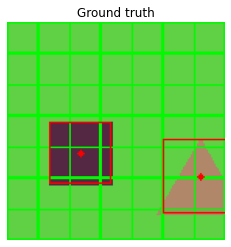

In [5]:
train_dataset = ShapesDataset(50, 140, 123)
train_dataset.show_bboxes(1)

In [6]:
# Cells with objects
train_dataset.show_cell_info(4, 2, 1)
train_dataset.show_cell_info(4, 6, 1)
# Empty cell
train_dataset.show_cell_info(0, 0, 1)


Cell: [4][2]
Boxes:
tensor([[0.3500, 0.2000, 0.2857, 0.2857, 1.0000],
        [0.3500, 0.2000, 0.2857, 0.2857, 1.0000]])
Class confidence: tensor([0., 0., 1.])
Name:square

Cell: [4][6]
Boxes:
tensor([[0.2000, 0.9500, 0.3429, 0.3429, 1.0000],
        [0.2000, 0.9500, 0.3429, 0.3429, 1.0000]])
Class confidence: tensor([0., 1., 0.])
Name:triangle

Cell: [0][0]
Boxes:
tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
Class confidence: tensor([0., 0., 0.])
Name:empty cell


In [7]:
class YOLO(nn.Module):

    def __init__(self, backbone: nn.Module, num_bboxes: int, num_classes: int):
        super(YOLO, self).__init__()

        self.backbone = backbone
        self.num_cells = 7
        self.num_bboxes = num_bboxes
        self.num_classes = num_classes
        self.output_shape = (-1, self.num_cells, self.num_cells,
                             5 * self.num_bboxes + self.num_classes)

        self.conv1 = nn.Conv2d(in_channels=96,
                               out_channels=48, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=48,
                               out_channels=5 * self.num_bboxes + self.num_classes, kernel_size=1)
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x: torch.Tensor) -> torch.Tensor:

        x = self.backbone(x)
        x = self.dropout(x)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.sigmoid(x)
        x = x.view(self.output_shape)
        return x

    def _inference(self, img: np.ndarray, device: str, transform: Callable) -> torch.Tensor:
        """
        :param img:       image input without preprocessing
        :param device:    cpu/gpu
        :param transform: callable input preprocessing
        :return: [S, S, 5 x B + C] tensor
        """

        if transform:
            img = transform(img)
        if x.dim() == 3:
            img = img.unsqueeze(0)
            
        with torch.no_grad():
            out = self.forward(img.to(device))
        
        return out
    
    def _get_bbox_scores(self, out: torch.Tensor, box_index: int) -> torch.Tensor:
        """
        Calculate cell scores for each bbox by multiplying P(class_i|obj) and P(obj)
        By default, box_index={4, 9}: 
            [x1, y1, w1, h1, p1(objectness)][x2, y2, w2, h2, p2(objectness)]
        :param out: inference output
        :param box_index: position of objectness score for a bounding box in a cell
        """
        return torch.cat([(out[:, :, 5*2:][:, :, label] * out[:, :, box_index]).unsqueeze(0) 
                          for label in range(self.num_classes)])
    
    def _decode(self, out: torch.Tensor, bboxes_scores: tuple or list, 
                img_size: int, conf_thresh: float) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        
        """
        :param bboxes_scores:  scores, [[class_id, n_cells, n_cells],...]
        :param img_size:       input img size
        :param conf_thresh: confidence threshold
        :return: bounding boxes, scores and class labels
        """
        
        out_classes = torch.Tensor([])
        out_bboxes = torch.Tensor([])
        out_scores = torch.Tensor([])
        cell_size = 1 / self.num_cells
        
        for box_id, box_scores in enumerate(bboxes_scores):
            
            class_ids, rows, cols = torch.where(box_scores > conf_thresh)
            
            bboxes = out[rows, cols, 5*box_id: 5*box_id + 4].clone()
            bboxes_scores = box_scores[class_ids, rows, cols].clone()

            cols_rows = torch.vstack([cols, rows]).T
            
            x0y0_normalized = cols_rows * cell_size
            xy_normalized = bboxes[:, :2] * cell_size + x0y0_normalized
            wh_normalized = bboxes[:, 2:]

            boxes_xywh = torch.zeros((bboxes.shape[0], 4))
            boxes_xywh[:, :2] = xy_normalized - 0.5 * wh_normalized
            boxes_xywh[:, 2:] = wh_normalized

            boxes_xywh *= torch.repeat_interleave(torch.Tensor([img_size]), 4).expand_as(boxes_xywh)
            boxes_xywh = boxes_xywh.ceil()
            
            out_classes = torch.cat([out_classes, class_ids])
            out_bboxes = torch.cat([out_bboxes, boxes_xywh])
            out_scores = torch.cat([out_scores, bboxes_scores])
        return out_bboxes, out_scores, out_classes
            
        
    def detect(self, img: np.ndarray, conf_thresh: float, 
               transform: Callable = None, box_ids: tuple = (4, 9)) -> tuple:
        """
        :param img:
        :param conf_thresh:
        :param transform:
        :param box_ids:
        """
        img_size, _ , _ = img.shape
        device = next(self.parameters()).device.type
        
        output = self._inference(img, device, transform)[0].cpu()
        boxes_scores = [self._get_bbox_scores(output, b_id) for b_id in box_ids ]
        bboxes, scores, classes = self._decode(output, boxes_scores, img_size, conf_thresh) 
        
        bboxes, scores , classes =  \
        bboxes.ceil().numpy().astype(int), scores.numpy(), classes.numpy().astype(int)

        return bboxes, scores, classes

In [8]:
mbnet_backbone = torchvision.models.mobilenet_v2(pretrained=True, progress=False)
mbnet_backbone = nn.Sequential(*list(mbnet_backbone.features.children())[:-5])
yolo = YOLO(backbone=mbnet_backbone, num_bboxes=2, num_classes=3)

x = torch.Tensor(np.random.normal(size=(3, 140, 140)))
model_path = os.path.join('onnx_graphs', 'custom_yolov1.onnx')
torch.onnx.export(yolo, torch.unsqueeze(x, 0), model_path,
                  input_names=['input'], output_names=['output'], opset_version=10)

In [ ]:
netron.start(model_path, 30000)

In [9]:
transforms = [
    torchvision.transforms.ToPILImage(),
    torchvision.transforms.Resize((140, 140)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
]

In [10]:
datasets = {}
for name, n_images, seed in zip(('train', 'val', 'test'),
                                (5000, 250, 100),
                                (123, 321, 42)):
    datasets.update({name:
                     ShapesDataset(
                         n_images=n_images,
                         img_size=140,
                         seed=seed,
                         transform=torchvision.transforms.Compose(transforms),
                         name=name)
                     }
                    )

train Generating dataset...
val Generating dataset...
test Generating dataset...


In [11]:
n_classes = len(datasets['train'].shapes2d.classes)
num_boxes = 2
feature_size = 7

batch_size = 16
epochs = 30
l_rate = 0.001
device = 'cuda'

train_flag = False

In [12]:
# Init dataloaders
train_loader = DataLoader(datasets['train'], batch_size=batch_size)
val_loader = DataLoader(datasets['val'], batch_size=batch_size)
test_loader = DataLoader(datasets['test'], batch_size=batch_size)

mbnet_backbone = torchvision.models.mobilenet_v2(pretrained=True, progress=False)
mbnet_backbone = nn.Sequential(*list(mbnet_backbone.features.children())[:-5])
yolo = YOLO(backbone=mbnet_backbone, num_bboxes=2, num_classes=3)
yolo = yolo.to(device)

In [13]:
criterion = training.YOLOLoss(feature_size=feature_size, num_bboxes=num_boxes, num_classes=n_classes)

if train_flag:
    optimizer = torch.optim.Adam(yolo.parameters(), lr=l_rate)
    training.train_model(train_loader=train_loader,
                         val_loader=val_loader,
                         dataset_name='shapes2d',
                         model=yolo,
                         model_name='yolo_mbnet',
                         optimizer=optimizer,
                         criterion=criterion,
                         checkpoint_dir=os.path.join(
                             '.', 'saved_models', 'yolo_mbnet'),
                         checkpoint_metric='loss',
                         epochs=epochs,
                         device=device)
else:
    path = glob.glob(os.path.join('.', 'saved_models',
                     'yolo_mbnet', 'yolo_mbnet_shapes2d*.pt'))[0]
    print(f'Loading weights: {path}')
    yolo.load_state_dict(torch.load(path, map_location=device))
    yolo = yolo.eval()

Loading weights: ./saved_models/yolo_mbnet/yolo_mbnet_shapes2d_29_1.2412.pt


Calculate loss for test subset:

In [14]:
test_engine = create_supervised_evaluator(
    yolo.to(device),
    device=device,
    metrics={'loss': Loss(criterion)}
)
state = test_engine.run(test_loader)
state.metrics

{'loss': 0.6911354827880859}

In [15]:
shapes2d = utils.RandomShapes(img_size=140, w=40, h=40, seed=512)
test_image = shapes2d.get_image()[0]
boxes, scores, classes = yolo.detect(test_image, 0.3, torchvision.transforms.Compose(transforms))

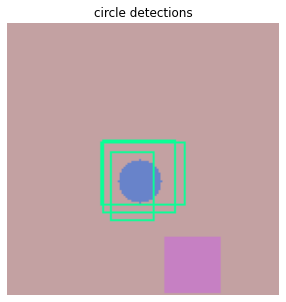

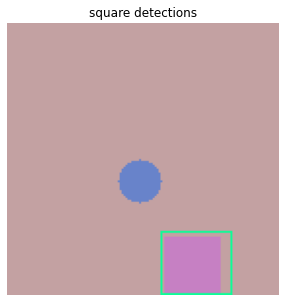

In [16]:
for class_idx in np.unique(classes):
    img_copy = test_image.copy()
    for pts in boxes[classes==class_idx]:
        cv2.rectangle(img_copy, pts, (10, 255, 150), 1)
    fig = plt.figure(figsize=(5,5))
    plt.imshow(img_copy)
    plt.title(f'{shapes2d.classes[class_idx]} detections')
    plt.axis('off')

### YOLO9000: Better, Faster, Stronger (Redmon J., Farhadi A., 2017)
[Paper](https://arxiv.org/abs/1612.08242)


* YOLO main drawbacks:

    * A significant number of localization error compared to Fast/Faster RCNN
    
    * Struggles to detect close objects
    
    * Low recall 
    
    * One target cell connected to the ground truth bboxes 
    
    
* What's new:

    * BatchNorm (because of GoogleNet default backbone)
    * High resolution classifier, from 224x224 input to 416x416 (to get the odd number of cells and, thus, a single center cell on a grid) with 13x13 feature map (32x downsampling).
    * No fully connected layers
    * Anchor boxes from Faster RCNN 
    * Generate prior anchors with k-means GT bboxes (default K=5)
    
    
<img src="../assets/6_yolo.png" width="450">

* 
    * Instead of predicting offsets YOLO still predict location coordinates relative to the location of the grid cell, which still boundshround truth to [0,1].
    * Second feature map 26x26 to detect smaller objects
    * Multi-scale training with input sizes: {320, 352, ..., 608}
    
    
<img src="../assets/4_yolo.png" width="750">


*Note: mAP or mAp@IoU, class averaged area under Precision-Recall curve*



<img src="../assets/5_yolo.png" width="450">

The model inspired researchers to new improvement ideas:

### Fast YOLO: A fast you only look once system for real-time embedded object detection in video (Shafiee M. J. et al., 2017)
[Paper](https://arxiv.org/abs/1709.05943)


### YOLOv3: An Incremental Improvement (Redmon J., Farhadi A., 2018)
[Paper](https://arxiv.org/abs/1804.02767)



### YOLOv4: Optimal Speed and Accuracy of Object Detection (Bochkovskiy A. et al., 2020)
[Paper](https://arxiv.org/abs/2004.10934)



### YOLOv5 (Glenn Jocher, 2020)
[GitHub](https://github.com/ultralytics/yolov5)



### YOLOX: Exceeding YOLO Series in 2021 (Ge Z. et al., 2021)
[Paper](https://arxiv.org/abs/2107.08430)


Architectures based on experiments with [PaddlePaddle](https://github.com/PaddlePaddle/Paddle) ML platfrom

### PP-YOLO: An Effective and Efficient Implementation of Object Detector (Long X. et al., 2020)
[Paper](https://arxiv.org/abs/2007.12099)


### PP-YOLOv2: A Practical Object Detector (Huang X. et al., 2021)
[Paper](https://arxiv.org/abs/2104.10419)

#### References

* https://docs.ultralytics.com/#the-history-of-yolo
* https://github.com/ultralytics/yolov5
* https://github.com/PaddlePaddle/Paddle/tree/develop/doc